In [2]:
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import gzip

In [3]:
batch_size = 10

In [4]:
mnist = torchvision.datasets.MNIST('../', download=True)
X, y = mnist.data, mnist.targets
X.size(), y.size()

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [5]:
train_images_byte = gzip.open('../MNIST/raw/train-images-idx3-ubyte.gz','r')
train_images_byte.read(16) # Skip the first 16 bytes

# Define the image size and the number of images to read
image_size = 28
sample_size = 60000

# Read the bytes and convert them into a numpy array
buf = train_images_byte.read(image_size * image_size * sample_size)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
images = data.reshape(sample_size, image_size, image_size)

# Do the same for the labels
train_labels_byte = gzip.open('../MNIST/raw/train-labels-idx1-ubyte.gz','r')
train_labels_byte.read(8) # Skip the first 8 bytes
buf = train_labels_byte.read(sample_size)
labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)

In [6]:
images.shape, labels.shape

((60000, 28, 28), (60000,))

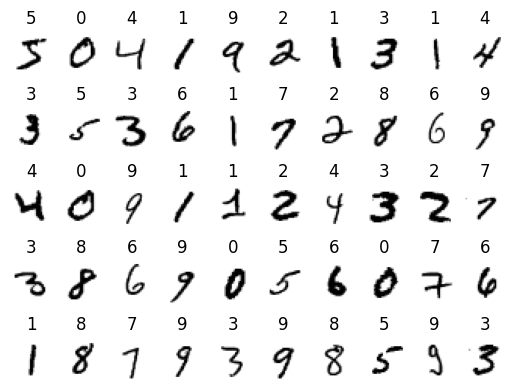

In [7]:
fig, axes = plt.subplots(5, batch_size)
for i in range(5):
    for j in range(batch_size):
        axes[i][j].imshow(images[batch_size*i+j], cmap='binary');
        axes[i][j].set_title(int(labels[batch_size*i+j]))
        axes[i][j].axis("off")

# Dataset

In [8]:
class MNISTDataset(Dataset):
    def __init__(self):
        self.image_size = 28
        self.n_samples = 60000
        self.images_filename = '../MNIST/raw/train-images-idx3-ubyte.gz'
        self.labels_filename = '../MNIST/raw/train-labels-idx1-ubyte.gz'

    def __getitem__(self, index):
        train_images_byte = gzip.open(self.images_filename,'r')
        # Skip bytes before image with current index
        train_images_byte.read(16 + image_size * image_size * index)
        buf = train_images_byte.read(self.image_size * self.image_size)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        image = torch.from_numpy(data.reshape(image_size, image_size))
        
        train_labels_byte = gzip.open(self.labels_filename,'r')
        train_labels_byte.read(8 + index)
        buf = train_labels_byte.read(1)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        label = torch.from_numpy(data)

        return image, label

    def __len__(self):
        return self.n_samples

In [9]:
dataset = MNISTDataset()

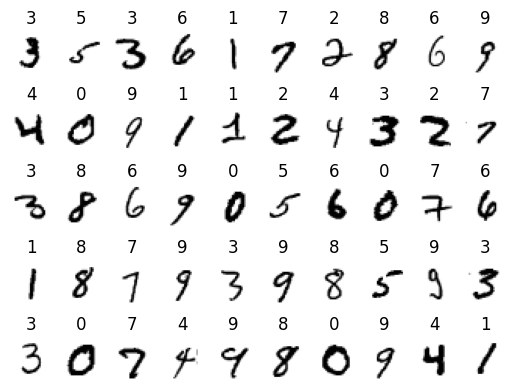

In [10]:
dataloader = DataLoader(dataset, batch_size=batch_size)
dataiter = iter(dataloader)
data = next(dataiter)

fig, axes = plt.subplots(5, batch_size)
for i in range(5):
    images, labels = next(dataiter)
    for j in range(batch_size):
        axes[i][j].imshow(images[j], cmap='binary');
        axes[i][j].set_title(int(labels[j]))
        axes[i][j].axis("off")

# Dataset Transforms

In [30]:
from torchvision.transforms import Compose

In [50]:
class MNISTDataset(Dataset):
    def __init__(self, transform = None):
        self.image_size = 28
        self.n_samples = 60000
        self.images_filename = '../MNIST/raw/train-images-idx3-ubyte.gz'
        self.labels_filename = '../MNIST/raw/train-labels-idx1-ubyte.gz'
        self.transform = transform

    def __getitem__(self, index):
        train_images_byte = gzip.open(self.images_filename,'r')
        train_images_byte.read(16 + image_size * image_size * index)
        buf = train_images_byte.read(self.image_size * self.image_size)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        image = data.reshape(image_size, image_size)
        
        train_labels_byte = gzip.open(self.labels_filename,'r')
        train_labels_byte.read(8 + index)
        buf = train_labels_byte.read(1)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        label = data

        if self.transform:
            sample = image, label
            image, label = self.transform(sample)

        return image, label

    def __len__(self):
        return self.n_samples
    
class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)
    
class SubTransform:
    def __init__(self, sub):
        self.sub = sub

    def __call__(self, sample):
        inputs, targets = sample
        targets -= self.sub
        return inputs, targets
    

In [51]:
dataset = MNISTDataset()
dataset[0][1]

array([5], dtype=int64)

In [52]:
dataset = MNISTDataset(transform=ToTensor())
dataset[0][1]

tensor([5])

In [53]:
dataset = MNISTDataset(transform=Compose([ToTensor(), SubTransform(1)]))
dataset[0][1]

tensor([4])